In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Direct risk matrix (r)
def calculate_direct_risk_matrix(direct_likelihood_matrix, direct_impact_matrix):
    return (np.array(direct_likelihood_matrix)*np.array(direct_impact_matrix)).tolist()

In [3]:
def propagation_tree(graph,source,target,cutoff=None):

    propagation_tree = nx.DiGraph()

    for path in list(nx.all_simple_paths(graph, source, target, cutoff)):
        new_path = []
        for level, node in enumerate(path, 1):
            node_id = ""
            for i in range(level):
                if i == 0:
                    node_id = str(path[i])
                else:
                    node_id = node_id + "-" + str(path[i])
            node_name = node
            node_level = level
            new_path.append(node_id)
            propagation_tree.add_node(node_id, name=node_name, level=node_level)
        nx.add_path(propagation_tree, new_path)
    
    return propagation_tree

def plot_propagation_tree(propagation_tree):
        labels = nx.get_node_attributes(propagation_tree, 'name') 
        pos = hierarchy_pos(propagation_tree)
        plt.figure(figsize=(40,10))
        options = {"with_labels": True, 
                "node_shape": "s", 
                "arrows": False,
                "node_color": "white", 
                "edgecolors": "black", 
                "node_size": 1500}
        nx.draw_networkx(propagation_tree, 
                        pos=pos, 
                        labels=labels, 
                        **options)

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
        the root will be found and used
    - if the tree is directed and this is given, then 
        the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
        then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [4]:
# Combined likelihood matrix (L)
def calculate_combined_likelihood_matrix(design_structure_matrix,direct_likelihood_matrix,cutoff):
    '''Returns the Combined likelihood matrix (L)'''
    number_elements = len(design_structure_matrix)
    g = nx.from_numpy_matrix(np.transpose(np.matrix(design_structure_matrix)), create_using=nx.DiGraph)
    combined_likelihood_matrix = [[0 for col in range(number_elements)] for row in range(number_elements)]
    for target, row in enumerate(design_structure_matrix):
        for source, element in enumerate(row):
            if target != source:
                #print(f"Change source: {source} Change target: {target}")
                # DiGraph representing the propagation tree
                tree = propagation_tree(g,source,target,cutoff)
                #plot_propagation_tree(tree)
                # List of paths from longest to shortest
                nodes_list = list(reversed(sorted(tree.nodes, key=len)))
                # For each node (representing path in the tree)
                for node in nodes_list:
                    #print(f"Node: {node}  Data: {tree.nodes[node]}")
                    # List of parents, i.e. paths (should be only one, except for the root) that lead to the current path (node) 
                    parents = list(tree.predecessors(node))
                    #print(f"Parents: {parents}")
                    # List of children, i.e. paths that are descendants of the current path (node)
                    children = list(tree.successors(node))
                    #print(f"Children: {children}")
                    if parents != []:
                        parent = parents[0]
                        #print(f"Node: {node}  Data: {tree.nodes[node]} Parent: {parent} Children: {children}")
                        # If the node is a leaf
                        if len(children) == 0:
                            tree.edges[parent,node]['likelihood'] = direct_likelihood_matrix[tree.nodes[node]['name']][tree.nodes[parent]['name']]
                        elif len(children) == 1:
                            child = children[0]
                            tree.edges[parent,node]['likelihood'] = tree.edges[node,child]['likelihood']
                        else:
                            temp = 1
                            for child in children:
                                temp = temp * (1 - tree.edges[node,child]['likelihood'])
                            tree.edges[parent,node]['likelihood'] = 1 - temp
                        #print(f"Likelihood: {tree.edges[parent,node]['likelihood']}")
                    else:
                        #print(f"Node: {node}  Data: {tree.nodes[node]} Children: {children}")
                        #print(f"Root node reached")
                        temp = 1
                        for child in children:
                            temp = temp * (1 - tree.edges[node,child]['likelihood'])
                        likelihood = 1 - temp
                        #print(f"Likelihood_{source},{target}: {likelihood}")
                        combined_likelihood_matrix[target][source] = likelihood
    return combined_likelihood_matrix

In [5]:
# Combined risk matrix (R)
def calculate_combined_risk_matrix(design_structure_matrix,direct_likelihood_matrix,direct_impact_matrix,combined_likelihood_matrix,cutoff):
    '''Returns the Combined risk matrix (R)'''
    number_elements = len(design_structure_matrix)
    g = nx.from_numpy_matrix(np.transpose(np.matrix(design_structure_matrix)), create_using=nx.DiGraph)
    combined_risk_matrix = [[0 for col in range(number_elements)] for row in range(number_elements)]
    for target, row in enumerate(design_structure_matrix):
        for source, element in enumerate(row):
            if target != source:
                #print(f"Change source: {source} Change target: {target}")
                all_simple_paths = list(nx.all_simple_paths(g, source, target, cutoff))
                #print(f"Number of paths: {len(all_simple_paths)}")
                #print(all_simple_paths)
                penultimates = set()
                for path in all_simple_paths:
                    #print(f"Path: {path}")
                    penultimates.add(path[-2])
                #print(f"Penultimates: {penultimates}")
                temp = 1
                for penultimate in penultimates:
                    temp = temp * (1 - combined_likelihood_matrix[penultimate][source] * direct_likelihood_matrix[target][penultimate] * direct_impact_matrix[target][penultimate])
                combined_risk_matrix[target][source] = 1 - temp
    return combined_risk_matrix

In [6]:
# Combined impact matrix (I)
def calculate_combined_impact_matrix(design_structure_matrix,combined_likelihood_matrix,combined_risk_matrix):
    '''Returns the Combined impact matrix (I)'''
    number_elements = len(design_structure_matrix)
    combined_impact_matrix = [[0 for col in range(number_elements)] for row in range(number_elements)]

    for i, row in enumerate(combined_risk_matrix):
        for j,element in enumerate(row):
            if i != j and combined_likelihood_matrix[i][j] != 0:
                combined_impact_matrix[i][j] = combined_risk_matrix[i][j]/combined_likelihood_matrix[i][j]
    return combined_impact_matrix

In [7]:
# Product elements
product_elements = ['power supply',
                    'motor',
                    'heating unit',
                    'fan',
                    'control system',
                    'casing']

# Design structure Matrix (DSM)
design_structure_matrix =  [[0,1,1,0,0,0],
                            [1,0,0,1,1,1],
                            [1,0,0,1,1,1],
                            [1,1,1,0,0,1],
                            [0,0,1,1,0,1],
                            [1,1,1,1,1,0]]

# Direct likelihood matrix (l)
direct_likelihood_matrix = [[0.0,0.3,0.3,0.0,0.0,0.0],
                            [0.9,0.0,0.0,0.6,0.3,0.6],
                            [0.9,0.0,0.0,0.6,0.3,0.6],
                            [0.3,0.6,0.9,0.0,0.0,0.9],
                            [0.0,0.0,0.3,0.6,0.0,0.3],
                            [0.3,0.9,0.6,0.9,0.6,0.0]]

# Direct impact matrix (i)
direct_impact_matrix =     [[0.0,0.9,0.9,0.0,0.0,0.0],
                            [0.9,0.0,0.0,0.6,0.3,0.3],
                            [0.6,0.0,0.0,0.3,0.3,0.3],
                            [0.3,0.3,0.6,0.0,0.0,0.3],
                            [0.0,0.0,0.3,0.3,0.0,0.3],
                            [0.3,0.6,0.6,0.9,0.6,0.0]]

cutoff = 3

In [12]:
direct_risk_matrix = calculate_direct_risk_matrix(
    direct_likelihood_matrix,
    direct_impact_matrix
    )
direct_risk_matrix

[[0.0, 0.27, 0.27, 0.0, 0.0, 0.0],
 [0.81, 0.0, 0.0, 0.36, 0.09, 0.18],
 [0.54, 0.0, 0.0, 0.18, 0.09, 0.18],
 [0.09, 0.18, 0.54, 0.0, 0.0, 0.27],
 [0.0, 0.0, 0.09, 0.18, 0.0, 0.09],
 [0.09, 0.54, 0.36, 0.81, 0.36, 0.0]]

In [8]:
def calculate_all_matrices(
        design_structure_matrix,
        direct_likelihood_matrix,
        direct_impact_matrix,
        cutoff
    ):
    '''Returns all matrices'''
    combined_likelihood_matrix = calculate_combined_likelihood_matrix(
        design_structure_matrix,
        direct_likelihood_matrix,
        cutoff
    )
    combined_risk_matrix = calculate_combined_risk_matrix(
        design_structure_matrix,
        direct_likelihood_matrix,
        direct_impact_matrix,
        combined_likelihood_matrix,
        cutoff
    )
    combined_impact_matrix = calculate_combined_impact_matrix(
    design_structure_matrix,
    combined_likelihood_matrix,
    combined_risk_matrix
    )
    return combined_likelihood_matrix, combined_risk_matrix, combined_impact_matrix

In [9]:
combined_likelihood_matrix, combined_risk_matrix, combined_impact_matrix = calculate_all_matrices(
        design_structure_matrix,
        direct_likelihood_matrix,
        direct_impact_matrix,
        cutoff
    )

In [10]:

def plot_product_risk_matrix(product_elements,DSM,clm,cim,crm):

    n = len(DSM)
    x = []
    y = []
    for i in range(n):
        for j in range(n):
            x.append(j)
            y.append(i)

    dx = [item for sublist in clm for item in sublist]
    dy = [item for sublist in cim for item in sublist]
    z = [item for sublist in crm for item in sublist]

    cmap = plt.cm.coolwarm
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, aspect='equal')

    # Paint the grid for all elements
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_yticks(np.arange(0, n, 1))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    # Tick labels
    #TODO fix labels so the show in between ticks
    ax.set_xticklabels(product_elements)
    ax.set_yticklabels(product_elements)
    # for label in ax.get_xticklabels():
    #     label.set_horizontalalignment('center')

    for x, y, c, h, w in zip(x, y, z, dx, dy):
        ax.add_artist(Rectangle(xy=(x, y),
                    color=cmap(c),
                    width=w, height=h))

    #plt.ylabel(product_components)

    plt.xlim([0, n])
    plt.ylim([0, n])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.show()

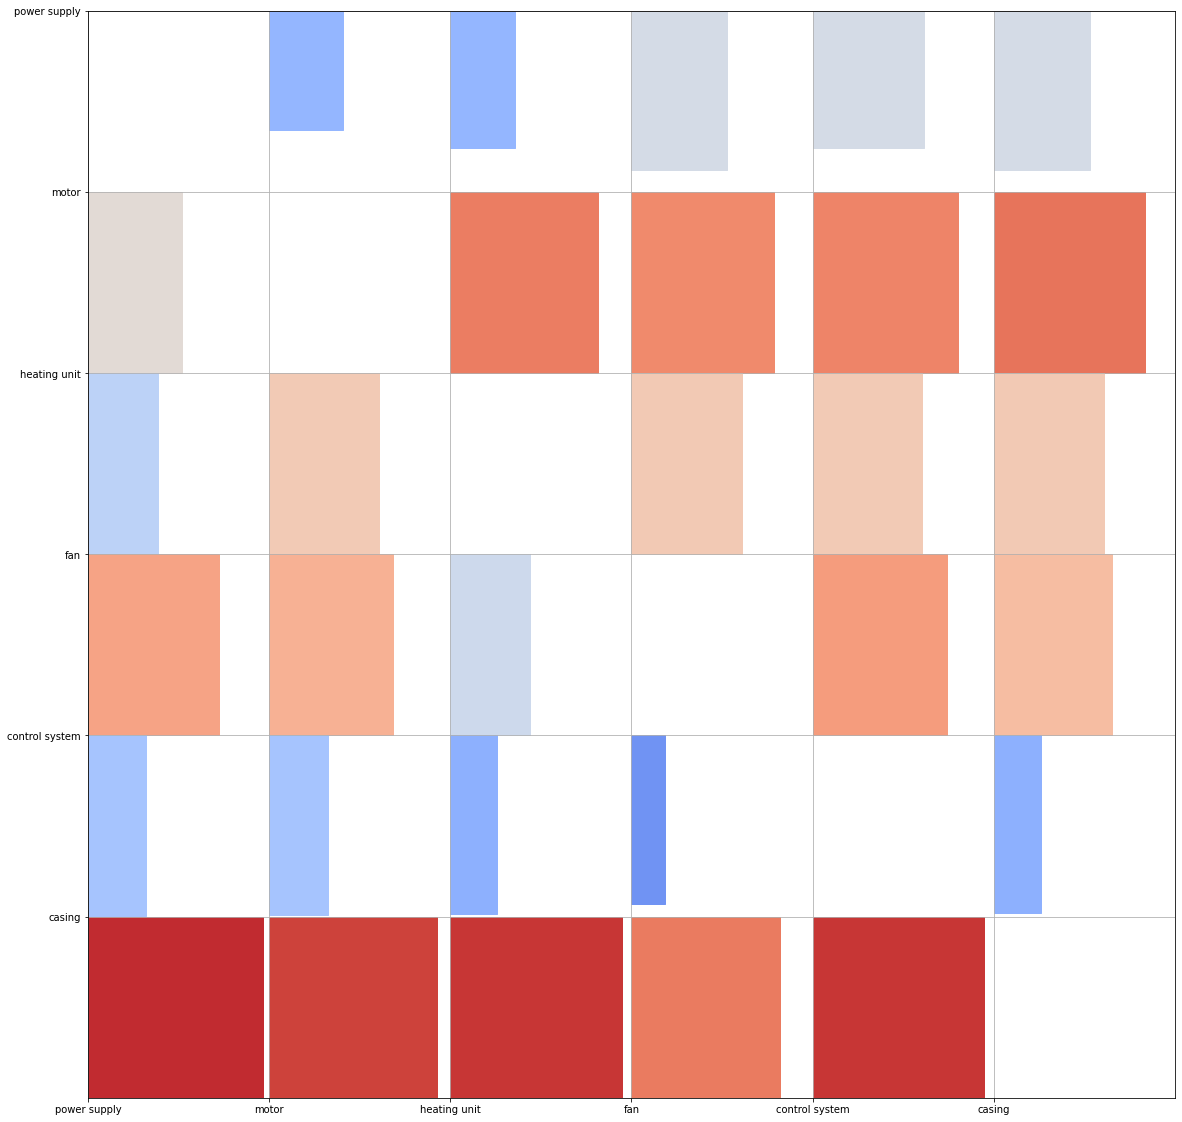

In [11]:
plot_product_risk_matrix(
    product_elements,
    design_structure_matrix,
    combined_likelihood_matrix,
    combined_impact_matrix,
    combined_risk_matrix
    )